## Test Diabetes dataset
- Document of dataset: 
    + https://archive.ics.uci.edu/dataset/34/diabetes
    + https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html
    + https://fairlearn.org/main/api_reference/generated/fairlearn.datasets.fetch_diabetes_hospital.html#fairlearn.datasets.fetch_diabetes_hospital


In [1]:
# Custom imports
# import my_helper # my helper functions
from TabResNet import TabResNet
from MLP import MLP

# General imports
from IPython.display import Markdown, display, clear_output
from functools import partial
import pathlib
import numpy as np
import pandas as pd

# DL imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

# Choose the fairness metric
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

# Some "difference" metrics (as in Nils' paper)
# All ranges are [0,1] -> no need to scale 
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    true_positive_rate_difference,
    false_positive_rate_difference,
)

torch.manual_seed(27)
clear_output()
np.random.seed(27)

## Data Loading

In [55]:
# ---------------------------
# Data Loading and Preparation
# ---------------------------
from fairlearn.datasets import fetch_diabetes_hospital

# Data processing
X, y = fetch_diabetes_hospital(as_frame=True, return_X_y=True)
# The columns readmit_binary and readmitted are included in X -> remove both to avoid target leakage
X.drop(columns=["readmitted", "readmit_binary"], inplace=True)

In [56]:
y_df = pd.DataFrame(y)
print(y_df.value_counts(normalize=True))

readmit_30_days
0                  0.888401
1                  0.111599
Name: proportion, dtype: float64


## Data Preprocessing

### Remove Unknown/Invalid gender

In [57]:
# Get a boolean mask for rows where gender is not 'Unknown/Invalid' (which was encoded as 2)
valid_gender_mask = X['gender'] != 'Unknown/Invalid'

In [58]:
# Filter both X and y using the same mask
X = X[valid_gender_mask]
y = y[valid_gender_mask]

In [59]:
print("Remaining rows after removing 'Unknown/Invalid' gender values:")
print(X['gender'].value_counts())

Remaining rows after removing 'Unknown/Invalid' gender values:
gender
Female    54708
Male      47055
Name: count, dtype: int64


### Label Encoding

In [60]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [61]:
from sklearn.preprocessing import LabelEncoder
label_mappings = {}
# Apply LabelEncoder to each column and store mappings
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Show mappings
for col, mapping in label_mappings.items():
    print(f"\nEncoded mapping for '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} → {encoded}")


Encoded mapping for 'race':
  AfricanAmerican → 0
  Asian → 1
  Caucasian → 2
  Hispanic → 3
  Other → 4
  Unknown → 5

Encoded mapping for 'gender':
  Female → 0
  Male → 1

Encoded mapping for 'age':
  '30 years or younger' → 0
  '30-60 years' → 1
  'Over 60 years' → 2

Encoded mapping for 'discharge_disposition_id':
  'Discharged to Home' → 0
  Other → 1

Encoded mapping for 'admission_source_id':
  Emergency → 0
  Other → 1
  Referral → 2

Encoded mapping for 'medical_specialty':
  Cardiology → 0
  Emergency/Trauma → 1
  Family/GeneralPractice → 2
  InternalMedicine → 3
  Missing → 4
  Other → 5

Encoded mapping for 'primary_diagnosis':
  'Genitourinary Issues' → 0
  'Musculoskeletal Issues' → 1
  'Respiratory Issues' → 2
  Diabetes → 3
  Other → 4

Encoded mapping for 'max_glu_serum':
  >200 → 0
  >300 → 1
  None → 2
  Norm → 3

Encoded mapping for 'A1Cresult':
  >7 → 0
  >8 → 1
  None → 2
  Norm → 3

Encoded mapping for 'insulin':
  Down → 0
  No → 1
  Steady → 2
  Up → 3

Encod

### Over-sampling imbalanced class

In [62]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=7)
X_smote, y_smote = smote.fit_resample(X, y)


In [63]:
y_smote_df = pd.DataFrame(y_smote)
print(y_smote_df.value_counts(normalize=True))

readmit_30_days
0                  0.833335
1                  0.166665
Name: proportion, dtype: float64


In [64]:
X_le = X_smote.drop(columns=["gender"])

### Data Splitting & Formatting

In [65]:
random_state = 7
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_le, y_smote, X_smote["gender"], test_size=0.2, random_state=random_state
)

In [66]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of A_train: ", A_train.shape)
print("Shape of A_test: ", A_test.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (86789, 21)
Shape of y_train:  (86789,)
Shape of A_train:  (86789,)
Shape of A_test:  (21698,)
Shape of X_test:  (21698, 21)
Shape of y_test:  (21698,)


In [67]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# Convert all data to integers -> avoid errors in training
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)


# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np) #.type(torch.LongTensor) 

## Train

### MLP

In [78]:
INPUT_DIM     = X_test.shape[1]
NUM_CLASSES   = 2
HIDDEN_DIM    = 50
LEARNING_RATE = 1e-2


mlp_model = MLP(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=LEARNING_RATE)

In [86]:
# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    # Forward pass
    logits = mlp_model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/400], Loss: 0.4335
Epoch [200/400], Loss: 0.4324
Epoch [300/400], Loss: 0.4305
Epoch [400/400], Loss: 0.4277


In [87]:
# Evaluate on test data
mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(X_test_tensor) 
    probs = torch.softmax(logits, dim=1)
    mlp_preds = torch.argmax(probs, dim=1)
    accuracy = (mlp_preds == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8385


In [47]:
# Save the model
torch.save(mlp_model.state_dict(), "saved_model/mlp_diabetes.pth")

In [ ]:
# Load the model
mlp_model.load_state_dict(torch.load("saved_model/mlp_diabetes.pth"))

C:\Users\hungd\AppData\Local\Temp\ipykernel_21172\2015773111.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load("saved_model/mlp_german

<All keys matched successfully>

### TabResNet

In [71]:
# Instantiate model
model = TabResNet(
    d_in=X_test.shape[1], # Match input features
    d_out=2,
    n_blocks=2,
    d_block=32,
    d_hidden=64,
    dropout1=0.2,
    dropout2=0.05
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    # Forward pass
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/400], Loss: 0.4348
Epoch [200/400], Loss: 0.4226
Epoch [300/400], Loss: 0.4166
Epoch [400/400], Loss: 0.4134


In [73]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor) 
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8406


In [91]:
# Save the model
torch.save(mlp_model.state_dict(), "saved_model/tabresnet_diabetes.pth")

## Results

### Predicted positive counts by group (Diabetes):

In [74]:
# Combine into DataFrame for easy grouping
df_test = pd.DataFrame({
    'gender': A_test,
    'Label': y_test
})

# Count distribution of classes per group
distribution = df_test.groupby('gender')['Label'].value_counts(normalize=True).unstack()
print("Class distribution by gender group (as percentage) - Diabetes Dataset:")
print((distribution * 100).round(2))

Class distribution by gender group (as percentage) - Diabetes Dataset:
Label       0      1
gender              
0       81.22  18.78
1       86.11  13.89


Imbalance Assessment

Diabetes:

Gender 0 (likely female): 23.17% positive, Gender 1 (likely male): 16.09% positive.

Difference is just ~7 percentage points and both groups have fairly balanced representation.

Aligns with consistently high fairness scores (>0.95) across all models.

In [88]:
print("Predicted positive counts by group of Model MLP:")
print(pd.Series(mlp_preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model MLP:
gender
0    67
1    28
dtype: int64


In [76]:
print("Predicted positive counts by group of Model TabResNet:")
print(pd.Series(preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model TabResNet:
gender
0    105
1     43
dtype: int64


### MLP

array([[<Axes: title={'center': 'Accuracy'}, xlabel='gender'>,
        <Axes: title={'center': 'Precision'}, xlabel='gender'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='gender'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Count'}, xlabel='gender'>],
       [<Axes: xlabel='gender'>, <Axes: xlabel='gender'>,
        <Axes: xlabel='gender'>]], dtype=object)

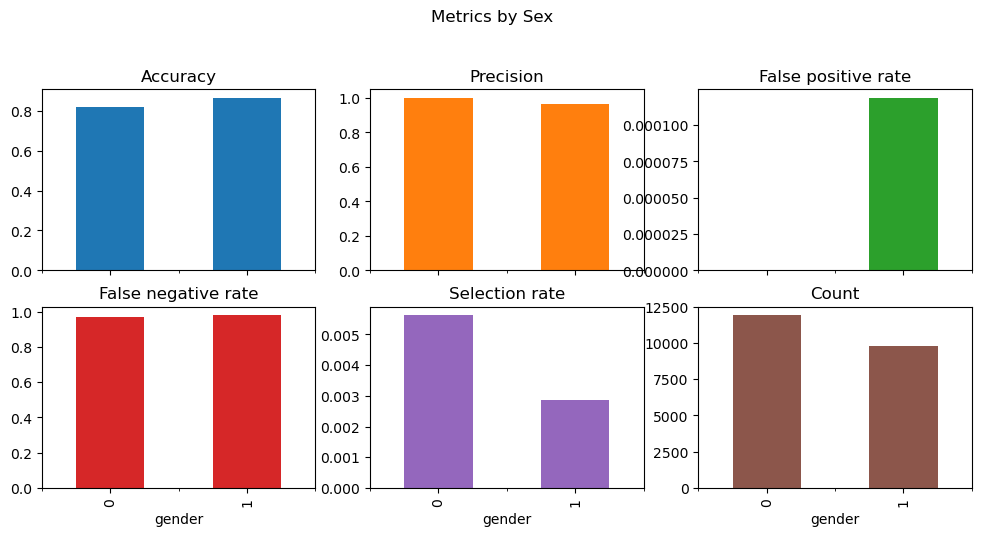

In [89]:
# Plot metrics using MetricFrame
mlp_metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

mlp_metric_frame = MetricFrame(
    metrics=mlp_metrics, y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test
)

# Plotting
mlp_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [90]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
mlp_accuracy_values = mlp_metric_frame.by_group["Accuracy"]
mlp_acc_diff = mlp_accuracy_values.max() - mlp_accuracy_values.min()
print(f"Accuracy difference: {mlp_acc_diff:.4f}")

# Precision difference
mlp_precision_values = mlp_metric_frame.by_group["Precision"]
mlp_prec_diff = mlp_precision_values.max() - mlp_precision_values.min()
print(f"Precision difference: {mlp_prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_tpr_values = 1 - mlp_metric_frame.by_group["False negative rate"]
mlp_tpr_diff = mlp_tpr_values.max() - mlp_tpr_values.min() 
print(f"True positive rate difference: {mlp_tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_fpr_values = mlp_metric_frame.by_group["False positive rate"]
mlp_fpr_diff = mlp_fpr_values.max() - mlp_fpr_values.min()
print(f"False positive rate difference: {mlp_fpr_diff:.4f}")

# Demographic parity (DemP) difference
mlp_dp_diff = demographic_parity_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Demographic parity difference: {mlp_dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
mlp_eo_diff = equalized_odds_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Equalized odds difference: {mlp_eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0459
Precision difference: 0.0357
True positive rate difference: 0.0101
False positive rate difference: 0.0001
Demographic parity difference: 0.0028
Equalized odds difference: 0.0101


### TabResNet

array([[<Axes: title={'center': 'Accuracy'}, xlabel='gender'>,
        <Axes: title={'center': 'Precision'}, xlabel='gender'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='gender'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Count'}, xlabel='gender'>],
       [<Axes: xlabel='gender'>, <Axes: xlabel='gender'>,
        <Axes: xlabel='gender'>]], dtype=object)

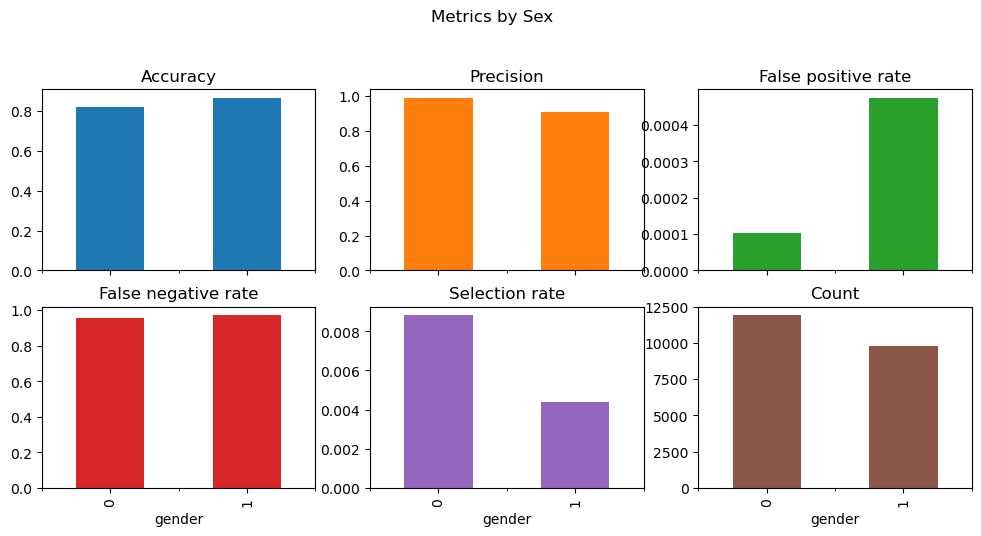

In [84]:
# Plot metrics using MetricFrame
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=preds, sensitive_features=A_test
)

# Plotting
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [85]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
accuracy_values = metric_frame.by_group["Accuracy"]
acc_diff = accuracy_values.max() - accuracy_values.min()
print(f"Accuracy difference: {acc_diff:.4f}")

# Precision difference
precision_values = metric_frame.by_group["Precision"]
prec_diff = precision_values.max() - precision_values.min()
print(f"Precision difference: {prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
tpr_values = 1 - metric_frame.by_group["False negative rate"]
tpr_diff = tpr_values.max() - tpr_values.min() 
print(f"True positive rate difference: {tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
fpr_values = metric_frame.by_group["False positive rate"]
fpr_diff = fpr_values.max() - fpr_values.min()
print(f"False positive rate difference: {fpr_diff:.4f}")

# Demographic parity (DemP) difference
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Demographic parity difference: {dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Equalized odds difference: {eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0438
Precision difference: 0.0835
True positive rate difference: 0.0178
False positive rate difference: 0.0004
Demographic parity difference: 0.0044
Equalized odds difference: 0.0178
